**IMDb**（Internet Movie Datebase ）是全球最大的互联网影视数据库，而[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) 是一个根据IMDB上电影评论而建立的数据集。它由斯坦福大学于 2011 年发布。

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [16]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf
from qbz95 import utils as qutils

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr



output_path = os.path.abspath('./output')
data_name = 'imdb'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['Negative', 'Positive']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'text_columns': 'snps_sa_comments',
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'stop_words':stopwords.words('english'),
    'batch_size': 32,    
    'max_features': 20000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':True,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':15},
        'rnn':{'dropout':0.4, 'embedding_dim':200, 'units':200, 'epochs':5},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':15},
        'sepcnn':{'dropout':0.4, 'epochs': 10, 'batch_size':128},
        'tl':{'dropout':0.4, 'trainable':True, 'layer_count':1, 'unit':64, 'epochs': 10},
        'pg':{'dropout':0.4, 'embedding_dim':300, 'units':80, 'epochs':20, 'learning_rate':0.0005},  
    },
    'embedding_paths':{
        'cc_en_300':os.path.join(word_vectors_path, 'snps', 'cc.en.300.vec'),
        'fasttext_crawl_300d_2M':os.path.join(word_vectors_path, 'fasttext-crawl-300d-2M.vec'),
        'glove_twitter_27B_200d':os.path.join(word_vectors_path, 'glove.twitter.27B.200d.txt')
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
model_results.clear()

2021-12-06 01:08:02,101: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json


### 下载数据

开始下载数据。

In [4]:
dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/aclImdb') 
if not os.path.exists(dataset_dir):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True)
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    print(dataset_dir)

![image-20201217095446441](images/image-20201217095446441.png)

下面是压缩文件解开后的目录结构。

![image-20201104115404253](images/image-20201104115404253.png)

其中train和test目录包含了实际的文本数据，详细说明见[IMDB](https://eipi10.cn/others/2020/10/22/dataset/#imdb---large-movie-review-dataset)。

### 查看数据

下面看一看实际的数据是啥样的。

In [5]:
def get_files(base_dir):
    pos_dir = os.path.join(base_dir, 'pos')
    pos_files = os.listdir(pos_dir)
    pos_files = [os.path.join(pos_dir, file_name) for file_name in pos_files]
    
    neg_dir = os.path.join(base_dir, 'neg')
    neg_files = os.listdir(neg_dir)
    neg_files = [os.path.join(neg_dir, file_name) for file_name in neg_files]    

    return pos_files, neg_files

train_pos_files, train_neg_files = get_files(os.path.join(dataset_dir, 'train'))
test_pos_files, test_files = get_files(os.path.join(dataset_dir, 'test'))
    
print('train dataset: {} positive reviews, {} negative reviews'.format(len(train_pos_files), len(train_neg_files)))
print('test dataset: {} positive reviews, {} negative reviews'.format(len(test_pos_files), len(test_files)))

train dataset: 12500 positive reviews, 12500 negative reviews
test dataset: 12500 positive reviews, 12500 negative reviews


![image-20201217115036617](images/image-20201217115036617.png)

首先看一看正面的评论。

In [6]:
for file_path in train_pos_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...') 

------------------------------/root/.keras/datasets/aclImdb/train/pos/127_7.txt------------------------------
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.
------------------------------/root/.keras/datasets/aclImdb/train/pos/126_10.txt------------------------------
Zentropa is the most original movie I've seen in y

![image-20201217111649607](images/image-20201217111649607.png)

然后看一看负面的评论。

In [7]:
for file_path in train_neg_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...')

------------------------------/root/.keras/datasets/aclImdb/train/neg/127_4.txt------------------------------
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher ...
------------------------------/root/.keras/datasets/aclImdb/train/neg/126_1.txt------

![image-20201217100213645](images/image-20201217100213645.png)

## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [8]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_imdb_sentiment_analysis_dataset(imdb_data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_imdb_sentiment_analysis_dataset(dataset_dir)

if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=25000, train_labels.shape=(25000,)
test_texts.length=25000, test_labels.shape=(25000,)


![image-20201217122349480](images/image-20201217122349480.png)

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

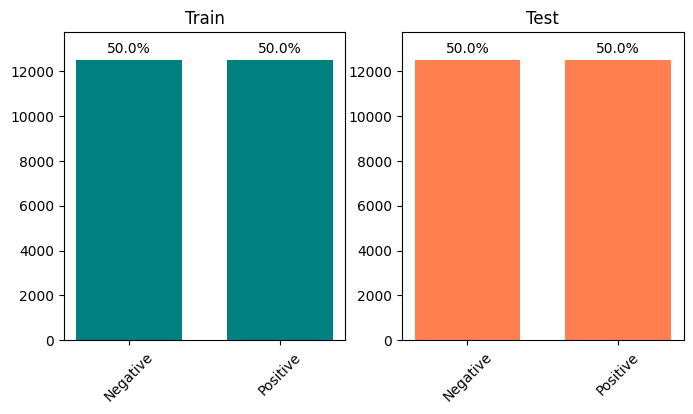

In [9]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

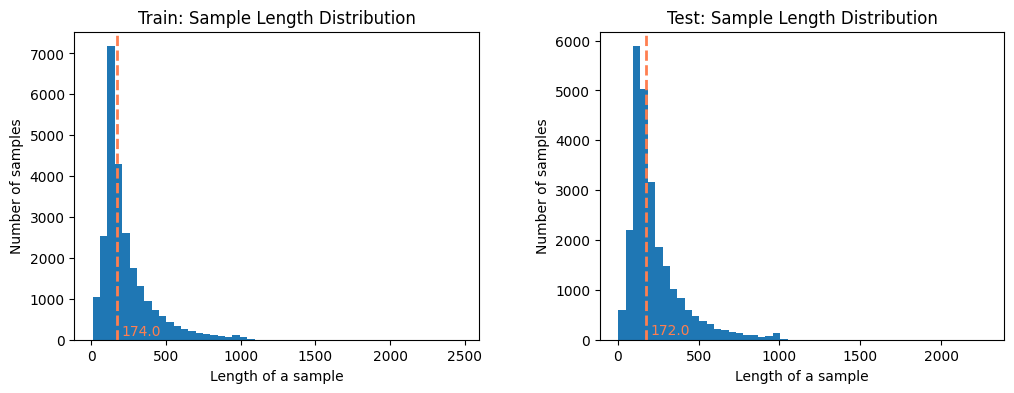

train：mean=233.79 variance=30181.96
test：mean=228.53 variance=28520.56


In [10]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
qtf.utils.plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))


通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [11]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3091,11744,4697,2321,1251,752,434,289,421,25000
train,2926,11654,4665,2385,1340,786,464,307,473,25000
合计,6017,23398,9362,4706,2591,1538,898,596,894,50000


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3008.5,11699.0,4681.0,2353.0,1295.5,769.0,449.0,298.0,447.0,25000.0
train,3008.5,11699.0,4681.0,2353.0,1295.5,769.0,449.0,298.0,447.0,25000.0
合计,6017.0,23398.0,9362.0,4706.0,2591.0,1538.0,898.0,596.0,894.0,50000.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [12]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 14.229826210223425
critical_value = 15.50731305586545
p_value = 0.07596828551367163



### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


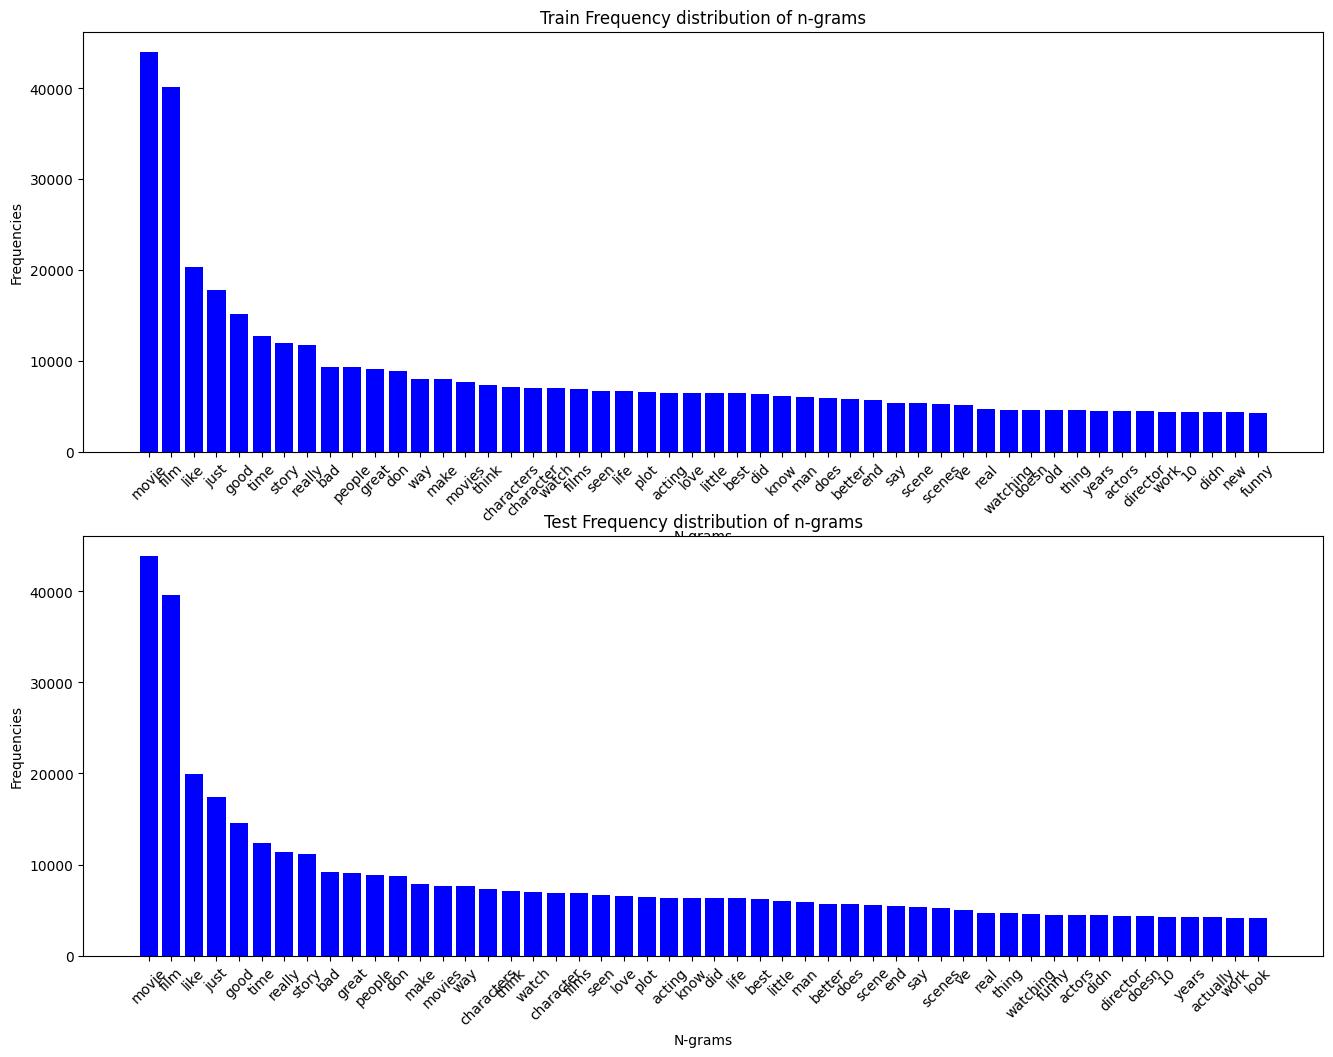

In [13]:
qtf.utils.plot_frequency_distribution(train_texts, test_texts) 

In [14]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 438729
Number of Vocabulary: 23078


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [15]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 143.7


可以看到这个比例大大小于15k，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下几个过程。
1. Standardization 
   
   文本标准化操作，去除一些不合规范的字符或单词等。比如：去除拼音和HTML标记
   
   
2. Tokenization

   把文本字符串拆分成Token。对于英文最常见的拆分方式是根据空格拆分
   
   
3. Vectorization

   把Token转化为向量。
   

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram + Preprocess

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [17]:
stop_words = params.stop_words if params.use_stop_words else None
generator = qtf.classification.NgramGenerator('ngram_preproess', standardize=qtf.text.standardize_text1,
                                    texts=train_texts, labels=train_labels, max_feature=params.max_features, 
                                    stop_words=stop_words)
ngram_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

2021-12-05 08:36:14.845305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6816 MB memory:  -> device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


In [18]:
data, labels = iter(ngram_datasets1.train_dataset).next()
print(type(data))
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(tf.sparse.to_dense(data), labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(np.any(item.numpy()>0), item.shape)

<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>
(32, 20000) (32,)
---------------------------------------- Positive ----------------------------------------
True (20000,)
---------------------------------------- Negative ----------------------------------------
True (20000,)
---------------------------------------- Positive ----------------------------------------
True (20000,)
---------------------------------------- Negative ----------------------------------------
True (20000,)
---------------------------------------- Negative ----------------------------------------
True (20000,)


2021-12-05 08:36:26.075917: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-05 08:36:26.188125: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Sequence + Preprocess

In [19]:
generator = qtf.classification.SequenceGenerator('sequence_prepross', standardize=qtf.text.standardize_text1, 
                                       texts=train_texts, max_features=params.max_features, 
                                       max_sequence_length=params.sequence_length)
sequence_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                                 generator=generator, batch_size=params.batch_size) 

In [20]:
data, labels = iter(sequence_datasets1.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 500) (32,)
---------------------------------------- Positive ----------------------------------------
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     

2021-12-05 08:36:50.634955: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### N-gram + Process

In [21]:
generator = qtf.classification.LayerGenerator.get_ngram_layer(name='ngram_map', standardize=qtf.text.standardize_tf_text1, 
                                                        texts=train_texts[0:1000], max_features=params.max_features)
ngram_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [22]:
data, labels = iter(ngram_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 20000) (32,)
---------------------------------------- Negative ----------------------------------------
[856.3619      7.3904395  40.915157  ...   0.          0.
   0.       ] (20000,)
---------------------------------------- Negative ----------------------------------------
[789.6324    14.780879  26.036919 ...   0.         0.         0.      ] (20000,)
---------------------------------------- Positive ----------------------------------------
[989.82086   22.171318  33.47604  ...   0.         0.         0.      ] (20000,)
---------------------------------------- Negative ----------------------------------------
[1623.7511     55.428295   26.036919 ...    0.          0.
    0.      ] (20000,)
---------------------------------------- Negative ----------------------------------------
[600.5655    29.561758  22.31736  ...   0.         0.         0.      ] (20000,)


2021-12-05 08:42:06.971796: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Sequence + Process

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。

In [23]:
ngrams = (1, 2)
output_mode = 'tf-idf'
max_sequence_length = None
data = train_texts[0:1000]

layer = TextVectorization(
            max_tokens=params.max_features, standardize=qtf.text.standardize_tf_text1,
            split='whitespace', ngrams=ngrams, output_mode=output_mode,
            output_sequence_length=max_sequence_length, pad_to_max_tokens=False,
            vocabulary=None
        )



In [24]:
generator = qtf.classification.LayerGenerator.get_sequence_layer(name='sequence_map', 
                                                       standardize=qtf.text.standardize_tf_text1, 
                                                       texts=train_texts[0:1000], 
                                                       max_features=params.max_features,
                                                       max_sequence_length=params.sequence_length)
sequence_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels,   
                                                 generator=generator, batch_size=params.batch_size)

In [25]:
data, labels = iter(sequence_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 500) (32,)
---------------------------------------- Negative ----------------------------------------
[   11     2   771  1936     7     2     1   170     4  2232     5     1
  1684  4211     2  2884   129     4     1    35     6  7122   421   182
     4     6   361  1196     3    13     3   649     5     2  1168     7
  2232    16  5071   580    30  1264    11     2   180     1     3   679
     9     6   242  1047   708     4   229     2   532     5   361   259
     9     6   195   306  1915     5  1561    17    12    18    11     1
  1473     3    13   175     2   457     2 11401    18  1758  2072    24
     1    16  8579    17     6  1188     5    29   478    17  4449  6582
     3     2   468    11     2   773    23    18     6   195    58  3535
     5     1     4    66  2279     6    74    42    14   138     3    89
     4     2  3297   924    26    17  3969   122     4  1238     2  2308
  1447     7     2  2884   129     1     1   190    26    17   528    46
   139     9  100

2021-12-05 08:42:11.140862: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [26]:
vocabulary = generator.layer.get_vocabulary()

embedding_files = [params.embedding_paths.fasttext_crawl_300d_2M]
embedding_matrix_fasttext = qtf.text.load_embedding_matrix(embedding_files,
                                                           vocabulary=vocabulary,
                                                           max_features=params.max_features,
                                                           max_length=1000000,
                                                           ignore_rows=0
                                                           )

2021-12-05 08:42:11,255: INFO: --------------------------------------------------------------------------------
2021-12-05 08:43:12,596: INFO: Loaded 1000000 word vectors. the vector size is 300
2021-12-05 08:43:12,636: INFO: embedding_matrix.shape: (19776, 300)
2021-12-05 08:43:12,637: INFO: match count: 17746
2021-12-05 08:43:12,637: INFO: missing word count: 2030




##  模型

### MLP

#### mp1

2021-12-05 08:43:13,084: INFO: model_params.mlp1.dropout=0.6
2021-12-05 08:43:13,084: INFO: model_params.mlp1.layer_count=1
2021-12-05 08:43:13,085: INFO: model_params.mlp1.units=256
2021-12-05 08:43:13,127: INFO: output_bias=[-0.69314718 -0.69314718]
2021-12-05 08:43:13,134: INFO: learning_rate=0.001
2021-12-05 08:43:13,135: INFO: model_params.mlp1.clip_value=None
2021-12-05 08:43:13,144: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1
2021-12-05 08:43:13,146: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1, monitor=val_accuracy)
2021-12-05 08:43:13,147: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-05 08:43:13,147: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-05 08:43:13,148: INFO: use LearningRateScheduler()
2021-12-05 08:43:13,148: 

SparseTensorSpec(TensorShape([32, 20000]), tf.float32)
Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
lambda (Lambda)              (None, 20000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5120256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 5,120,770
Trainable params: 5,120,770
Non-trainable params:

2021-12-05 08:43:17.570433: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1/assets


2021-12-05 08:43:18,179: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1/assets


Epoch 2/2
781/781 [==============================] - 3s 4ms/step - loss: 0.2601 - accuracy: 0.8914 - val_loss: 0.2678 - val_accuracy: 0.8917
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1/assets


2021-12-05 08:43:22,615: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1/assets
2021-12-05 08:43:22,641: INFO: finish training [elapsed time: 9.49 seconds]


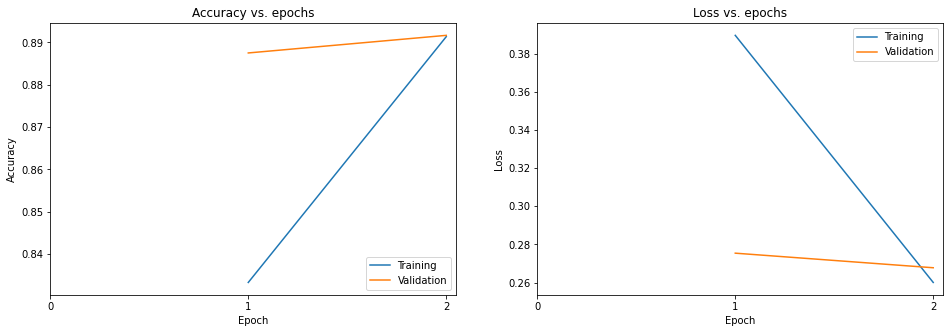

2021-12-05 08:43:22,911: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------
y_score.shape=(25000, 2)
y_true.shape=(25000, 2)
len(y_true.shape)=2


2021-12-05 08:44:10,866: INFO: test loss:0.2678
2021-12-05 08:44:10,866: INFO: test accuracy:0.8917
2021-12-05 08:44:10,867: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-05 08:44:10,868: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-05 08:44:10,869: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


y_score.shape=(25000, 2)
y_true.shape=(25000, 2)
len(y_true.shape)=2
----------------------------------------save model results and generator----------------------------------------


2021-12-05 08:44:11,457: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


----------------------------------------confusion matrix----------------------------------------


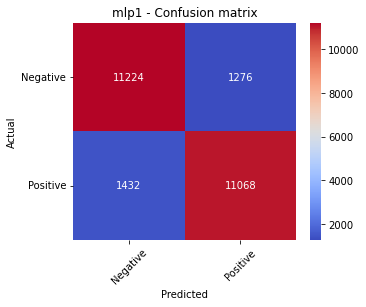

----------------------------------------sample analysis----------------------------------------
<class 'list'>
----------------------------------------1. Negative----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


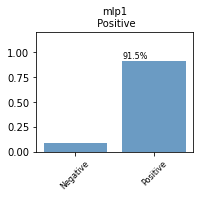

----------------------------------------2. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


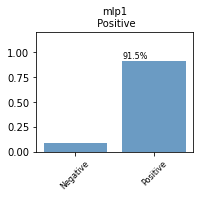

----------------------------------------3. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


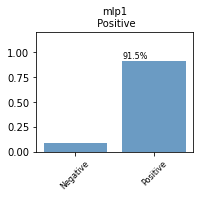

----------------------------------------4. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


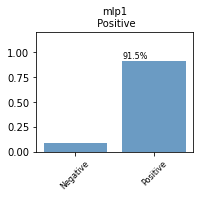

----------------------------------------5. Positive----------------------------------------
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.


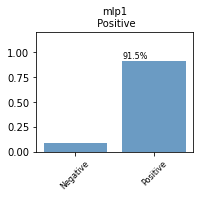

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,imdb_0721_p100.ipynb,5120770,9.5,2021-12-05 08:44,0.134,0.2678,0.9556,0.8917,0.9915,0.9564


In [27]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets1, model_results=model_results)
model = qtf.classification.text_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model, epochs=2)
helper.model_summary(model, history, show_sample_analysis=True)

#### mlp2

2021-12-05 08:44:35,229: INFO: model_params.mlp2.dropout=0.6
2021-12-05 08:44:35,230: INFO: model_params.mlp2.layer_count=1
2021-12-05 08:44:35,231: INFO: model_params.mlp2.units=256
2021-12-05 08:44:35,249: INFO: output_bias=[-0.69314718 -0.69314718]
2021-12-05 08:44:35,256: INFO: learning_rate=0.001
2021-12-05 08:44:35,257: INFO: model_params.mlp2.clip_value=None
2021-12-05 08:44:35,262: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2
2021-12-05 08:44:35,264: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2, monitor=val_accuracy)
2021-12-05 08:44:35,265: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-05 08:44:35,265: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-05 08:44:35,266: INFO: use LearningRateScheduler()
2021-12-05 08:44:35,266: 

TensorSpec(shape=(32, 20000), dtype=tf.float32, name=None)
Model: "mlp2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               5120256   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 5,120,770
Trainable params: 5,120,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
781/781 [==============================] - 28s 35

2021-12-05 08:45:03,716: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


Epoch 2/2
781/781 [==============================] - 3s 4ms/step - loss: 0.4451 - accuracy: 0.8097 - val_loss: 0.3454 - val_accuracy: 0.8847
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets


2021-12-05 08:45:07,776: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2/assets
2021-12-05 08:45:07,802: INFO: finish training [elapsed time: 32.53 seconds]


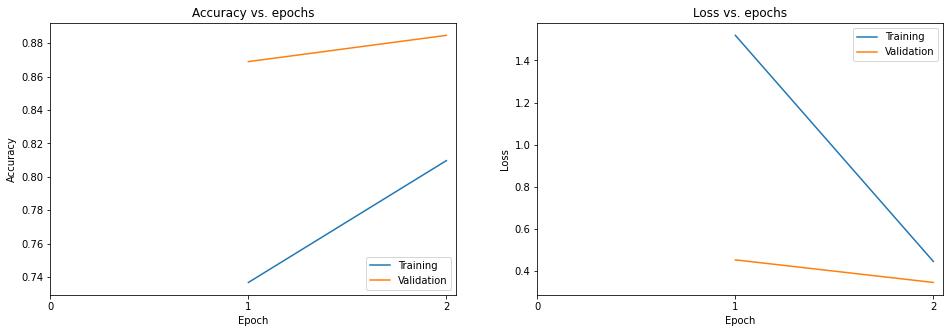

2021-12-05 08:45:08,062: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/mlp2
----------------------------------------evaluate----------------------------------------
y_score.shape=(25000, 2)
y_true.shape=(25000, 2)
len(y_true.shape)=2


2021-12-05 08:46:02,584: INFO: test loss:0.3454
2021-12-05 08:46:02,584: INFO: test accuracy:0.8847
2021-12-05 08:46:02,585: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-05 08:46:02,586: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-05 08:46:02,587: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_map.generator
2021-12-05 08:46:02,631: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_map.pkl
2021-12-05 08:46:02,633: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_map.generator
2021-12-05 08:46:02,633: INFO: loading model fro

y_score.shape=(25000, 2)
y_true.shape=(25000, 2)
len(y_true.shape)=2
----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-12-05 08:46:03,001: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


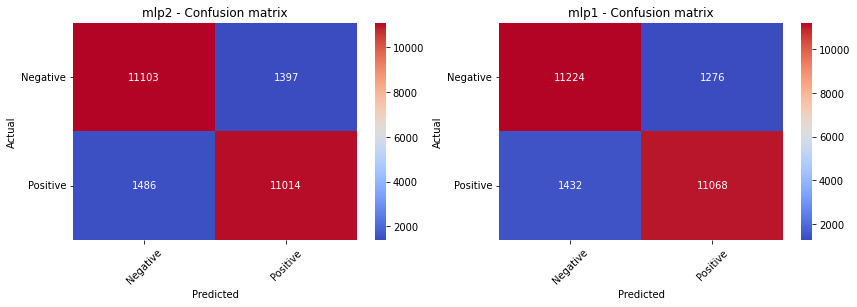

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,imdb_0721_p100.ipynb,5120770,9.5,2021-12-05 08:44,0.1340,0.2678,0.9556,0.8917,0.9915,0.9564
2,mlp2,imdb_0721_p100.ipynb,5120770,32.5,2021-12-05 08:46,0.2888,0.3454,0.9196,0.8847,0.9754,0.9504


In [28]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets2, model_results=model_results)
model = qtf.classification.text_models.mlp1(helper, name='mlp2')
model.summary()
history = helper.train(model, epochs=2)
helper.model_summary(model, history=history)

### Embedding

#### embedding1

In [29]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets1)
model = qtf.classification.models.embedding1(helper, name='embedding1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

AttributeError: module 'qbz95.tf.classification' has no attribute 'models'

#### embedding2

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.embedding1(helper, name='embedding2')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### sepCNN

#### sepcnn

In [ ]:
# helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
# model = qtf.classification.models.sepcnn1(helper, name='sepcnn', blocks=1)
# # when bolcks=2, the model can't converg
# model.summary()
# history = helper.train(model)
# helper.model_summary(model, history=history)

#### sepcnn_fasttext

In [ ]:
# helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
# model = qtf.classification.models.sepcnn1(helper, name='sepcnn_ft', blocks=1, 
#                    embedding_matrix=embedding_matrix_fasttext,
#                    is_embedding_trainable=False)
# model.summary()
# history = helper.train(model)
# helper.model_summary(model, history=history)

### LSTM

#### rnn_lstm

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.lstm1(helper, name='rnn_lstm')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### rnn_lstm_fasttext

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.lstm1(helper, name='rnn_lstm_ft',
                 embedding_matrix=embedding_matrix_fasttext,
                 is_embedding_trainable=False,
                 mask_zero=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### Pooled GRU 

#### pg_default

2021-12-05 08:47:01,034: INFO: model_params.pg_default.dropout=0.4
2021-12-05 08:47:01,035: INFO: model_params.pg_default.learning_rate=0.0005
2021-12-05 08:47:01,036: INFO: model_params.pg_default.clip_value=None
2021-12-05 08:47:01,036: INFO: batch_size=32
2021-12-05 08:47:01,037: INFO: max_features=20000
2021-12-05 08:47:01,038: INFO: model_params.pg_default.embedding_dim=300
2021-12-05 08:47:01,502: INFO: output_bias=[-0.69314718 -0.69314718]
2021-12-05 08:47:01,510: INFO: model_params.pg_default.clip_value=None
2021-12-05 08:47:01,515: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default
2021-12-05 08:47:01,517: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default, monitor=val_accuracy)
2021-12-05 08:47:01,518: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-05 08:47:01,519: INFO:

Model: "pg_default"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 300)     6000000     input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 500, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 500, 160)     183360      spatial_dropout1d[0][0]          
_________________________________________________________________________________________

2021-12-05 08:47:04.113483: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100


781/781 [==============================] - 39s 47ms/step - loss: 0.4175 - accuracy: 0.8062 - val_loss: 0.2971 - val_accuracy: 0.8755


2021-12-05 08:47:50,159: WARNING: Found untraced functions such as gru_cell_1_layer_call_fn, gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default/assets


2021-12-05 08:47:52,130: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default/assets
2021-12-05 08:47:52,459: INFO: finish training [elapsed time: 50.94 seconds]


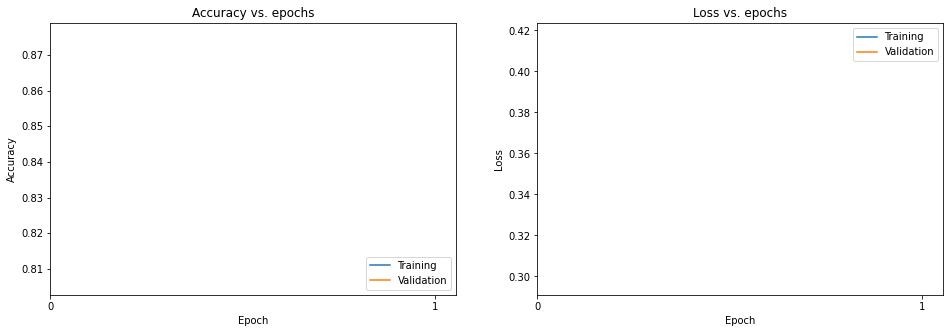

2021-12-05 08:47:52,722: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/pg_default
----------------------------------------evaluate----------------------------------------


2021-12-05 08:48:44,123: INFO: test loss:0.2971
2021-12-05 08:48:44,124: INFO: test accuracy:0.8755
2021-12-05 08:48:44,126: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-05 08:48:44,127: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json
2021-12-05 08:48:44,127: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2021-12-05 08:48:44,170: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.pkl
2021-12-05 08:48:44,172: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/sequence_map.generator
2021-12-05 08:48:44,172: INFO: loading 

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-12-05 08:48:44,501: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/ngram_preproess.generator


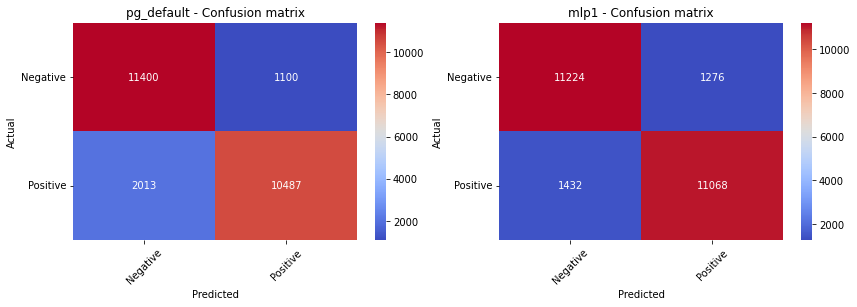

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,imdb_0721_p100.ipynb,5120770,9.5,2021-12-05 08:44,0.1340,0.2678,0.9556,0.8917,0.9915,0.9564
2,mlp2,imdb_0721_p100.ipynb,5120770,32.5,2021-12-05 08:46,0.2888,0.3454,0.9196,0.8847,0.9754,0.9504
3,pg_default,imdb_0721_p100.ipynb,6184002,50.9,2021-12-05 08:48,0.2285,0.2971,0.9208,0.8755,0.9741,0.9507


In [31]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.pooled_gru1(helper, name='pg_default')
model.summary()
history = helper.train(model, epochs=1) 
helper.model_summary(model, history=history)

#### pg_fasttext

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.pooled_gru1(helper, name='pg_ft', 
                       embedding_matrix=embedding_matrix_fasttext, 
                       is_embedding_trainable=False)
model.summary()
history = helper.train(model, epochs=2)
helper.model_summary(model, history=history)

## 评估

### 最佳模型

In [32]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10, columns=['program_name', 'model_name', 'create_time', 'test_loss', 'test_accuracy'])

2021-12-05 08:55:24,207: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb
2021-12-05 08:55:24,209: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/text_classification/output/imdb/imdb_0721_p100/results.json


,program_name,model_name,create_time,test_loss,test_accuracy
1,imdb_0721_p100.ipynb,mlp1,2021-12-05 08:44,0.2678,0.8917
2,imdb_0721_p100.ipynb,mlp2,2021-12-05 08:46,0.3454,0.8847
3,imdb_0721_p100.ipynb,pg_default,2021-12-05 08:48,0.2971,0.8755


In [22]:
# from qbz95.tf.classification import save_layer, load_layer, get_ngram_layer, get_sequence_layer

def save_layer(layer, layer_path):
    if layer_path.endswith('pkl'):
        obj = {'config': layer.get_config(),
               'weights': layer.get_weights()}
        qutils.pickle.ObjectPickle.save(layer_path, obj)
    else:
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Input(shape=(1,), dtype=tf.string))
        model.add(layer)
        model.save(layer_path, save_format="tf")


def load_layer(layer_path):
    if layer_path.endswith('pkl'):
        obj = qutils.pickle.ObjectPickle.load(layer_path)
        layer = tf.keras.layers.TextVectorization.from_config(obj['config'])
        layer.set_weights(obj['weights'])
    else:
        model = tf.keras.models.load_model(layer_path)
        layer = model.layers[0]
    return layer


def get_ngram_layer(standardize, texts, max_features):
    ngrams = (1, 2)
    output_mode = 'tf-idf'
    max_sequence_length = None
    return get_tv(standardize, texts, max_features,
                  ngrams=ngrams, output_mode=output_mode,
                  max_sequence_length=max_sequence_length)


def get_sequence_layer(standardize, texts, max_features, max_sequence_length):
    ngrams = None
    output_mode = 'int'
    return get_tv(standardize, texts, max_features,
                  ngrams=ngrams, output_mode=output_mode,
                  max_sequence_length=max_sequence_length)

def test(generator, layer=None):
#     dataset = generator(train_texts, labels=None, batch_size=32)
    dataset = get_dataset(layer, train_texts, labels=None, batch_size=32)
    data = iter(dataset).next()
    print(dataset)
    print(data.shape)    
    return data

def map_fun(layer):
    def map_(text):
        text = tf.expand_dims(text, axis=-1)
        return layer(text)[0]
    return map_

def get_ngram_layer(standardize, texts, max_features):
    ngrams = (1, 2)
    output_mode = 'tf-idf'
    max_sequence_length = None
    return get_tv(standardize, texts, max_features,
                  ngrams=ngrams, output_mode=output_mode,
                  max_sequence_length=max_sequence_length)


def get_sequence_layer(standardize, texts, max_features, max_sequence_length):
    ngrams = None
    output_mode = 'int'
    return get_tv(standardize, texts, max_features,
                  ngrams=ngrams, output_mode=output_mode,
                  max_sequence_length=max_sequence_length)


def get_tv(standardize, texts, max_features,
           ngrams, output_mode, max_sequence_length):
    layer = tf.keras.layers.TextVectorization(
        max_tokens=max_features, standardize=standardize,
        split='whitespace', ngrams=ngrams, output_mode=output_mode,
        output_sequence_length=max_sequence_length, pad_to_max_tokens=False,
        vocabulary=None
    )
    text_dataset = tf.data.Dataset.from_tensor_slices(texts)
    layer.adapt(text_dataset)
    return layer

def get_dataset(layer, data, labels, use_shuffle=False, batch_size=None, drop_remainder=False, use_cache=True):
    def map_(text):
        text = tf.expand_dims(text, axis=-1)
        return layer(text)[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((data,))
    dataset = dataset.map(lambda x: map_(x))
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE) 
    
#     if labels is None:
#         dataset = tf.data.Dataset.from_tensor_slices((data,))
#     else:
#         dataset = tf.data.Dataset.from_tensor_slices((data, labels))
#     if use_shuffle and labels is not None:
#         dataset = dataset.shuffle(len(labels), reshuffle_each_iteration=True)

#     if labels is None:
#         dataset = dataset.map(lambda x: map_(x))
#     else:
#         dataset = dataset.map(lambda x, y: (map_(x), y))

#     if batch_size is not None:
#         dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
#     if use_cache:
#         dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)  
    return dataset
    
# generator = qtf.classification.LayerGenerator.get_ngram_layer(name='ngram_map', 
#                                                               standardize=qtf.text.standardize_tf_text1, 
#                                                               texts=train_texts[0:1000], 
#                                                               max_features=params.max_features)
layer = get_ngram_layer(standardize=qtf.text.standardize_tf_text1, 
                                           texts=train_texts[0:1000], 
                                           max_features=params.max_features)
layer_save_format='.pkl'
data1 = test(generator, layer)
# generator_path = './output/imdb_0721_p100/my.generator'
# generator.before_pickle(generator_path)
# generator.after_pickle(generator_path)

layer_path= './output/imdb_0721_p100/my' + layer_save_format
save_layer(layer, layer_path)
layer = load_layer(layer_path)

data2 = test(generator, layer)
np.testing.assert_allclose(data1, data2)


print("="*50)
layer_save_format='.layer'
data1 = test(generator, layer)
# generator_path = './output/imdb_0721_p100/my.generator'
# generator.before_pickle(generator_path)
# generator.after_pickle(generator_path)

layer_path= './output/imdb_0721_p100/my' + layer_save_format
save_layer(layer, layer_path)
layer = load_layer(layer_path)

data2 = test(generator, layer)
np.testing.assert_allclose(data1, data2)

2021-12-06 01:31:00,265: INFO: save object to ./output/imdb_0721_p100/my.pkl


<PrefetchDataset shapes: (None, 20000), types: tf.float32>
(32, 20000)
<PrefetchDataset shapes: (None, 20000), types: tf.float32>
(32, 20000)
<PrefetchDataset shapes: (None, 20000), types: tf.float32>
(32, 20000)


2021-12-06 01:31:01,344: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: ./output/imdb_0721_p100/my.layer/assets


2021-12-06 01:31:02,096: INFO: Assets written to: ./output/imdb_0721_p100/my.layer/assets


2021-12-06 01:31:02,504: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


<PrefetchDataset shapes: (None, 20000), types: tf.float32>
(32, 20000)


In [21]:
# generator = qtf.classification.LayerGenerator.get_sequence_layer(name='sequence_map', 
#                                                                  standardize=qtf.text.standardize_tf_text1, 
#                                                                  texts=train_texts[0:1000], 
#                                                                  max_features=params.max_features,
#                                                                  max_sequence_length=params.sequence_length)
layer = get_sequence_layer(standardize=qtf.text.standardize_tf_text1, 
                                              texts=train_texts[0:1000], 
                                              max_features=params.max_features,
                                              max_sequence_length=params.sequence_length)
generator.layer_save_format='.pkl'
data1 = test(generator, layer)
# generator_path = './output/imdb_0721_p100/my.generator'
# generator.before_pickle(generator_path)
# generator.after_pickle(generator_path)

layer_path= './output/imdb_0721_p100/my' + generator.layer_save_format
save_layer(layer, layer_path)
layer = load_layer(layer_path)

data2 = test(generator, layer)
np.testing.assert_allclose(data1, data2)


print("="*50)
generator.layer_save_format='.layer'
data1 = test(generator, layer)
# generator_path = './output/imdb_0721_p100/my.generator'
# generator.before_pickle(generator_path)
# generator.after_pickle(generator_path)

layer_path= './output/imdb_0721_p100/my' + generator.layer_save_format
save_layer(layer, layer_path)
layer = load_layer(layer_path)

data2 = test(generator, layer)
np.testing.assert_allclose(data1, data2)

2021-12-06 01:28:52,480: INFO: save object to ./output/imdb_0721_p100/my.pkl


<PrefetchDataset shapes: (None, 500), types: tf.int64>
(32, 500)


InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [151], [batch]: [420] [Op:IteratorGetNext]

In [ ]:
predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
print(len(helper.datasets.train_data), len(helper.datasets.train_labels))
print(helper.datasets.train_data[0:2])
print(helper.datasets.train_labels[0:2])

predictor = predictors[0]
train_result = predictor.evaluate(helper.datasets.train_data, helper.datasets.train_labels)
train_result

In [ ]:
for predictor in predictors:
    print('-'*50)
#     print(predictor.model.summary())
    try:
        train_result = predictor.evaluate(helper.datasets.train_data, self.datasets.train_labels)
#         print(predictor.predict(train_texts[1:3]))
    except Exception as e:
        print(e)

In [ ]:


best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

In [ ]:
predictor = predictors[0]
predictor.generator.layer(train_texts[0:128]).shape

In [ ]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=False) 

In [ ]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [ ]:
results = best_predictor.evaluate(test_texts, test_labels)
print(results)

predictions = best_predictor.predict(test_texts)
print(predictions.shape)

In [ ]:
top1_predictions = best_predictor.predict_top_k(test_texts, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

In [ ]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)